# Final Project: Used Car Price Predictor
### Author: Satish Agrawal, Sanjay Jaras
### Bellevue University
### DSC 630 - Predictive Analytics

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import __version__ as mpv
import types
import seaborn as sns

from sklearn import __version__ as sklv
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor,LocalOutlierFactor
from sklearn.linear_model import SGDRegressor, LinearRegression, Lasso, BayesianRidge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

In [2]:
print('Using version %s of pandas' % pd.__version__)
print('Using version %s of numpy' % np.__version__)
print('Using version %s of matplotlib' % mpv)
print('Using version %s of seaborn' % sns.__version__)
print('Using version %s of sklearn' % sklv)

Using version 1.2.0 of pandas
Using version 1.19.2 of numpy
Using version 3.3.2 of matplotlib
Using version 0.11.1 of seaborn
Using version 0.24.0 of sklearn


## Configurations


In [3]:
%matplotlib inline
plt.style.use("seaborn-darkgrid")
random_state = 17
np.random.seed(random_state)

## Load Data
Data downloaded from https://www.kaggle.com/austinreese/craigslist-carstrucks-data


In [4]:
org_df = pd.read_csv("vehicles.csv", index_col=[0], converters={"cylinders":str}, parse_dates=["posting_date"])

### Show summary

In [5]:
org_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458213 entries, 0 to 458212
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            458213 non-null  int64  
 1   url           458213 non-null  object 
 2   region        458213 non-null  object 
 3   region_url    458213 non-null  object 
 4   price         458213 non-null  int64  
 5   year          457163 non-null  float64
 6   manufacturer  439993 non-null  object 
 7   model         453367 non-null  object 
 8   condition     265273 non-null  object 
 9   cylinders     458213 non-null  object 
 10  fuel          454976 non-null  object 
 11  odometer      402910 non-null  float64
 12  title_status  455636 non-null  object 
 13  transmission  455771 non-null  object 
 14  VIN           270664 non-null  object 
 15  drive         324025 non-null  object 
 16  size          136865 non-null  object 
 17  type          345475 non-null  object 
 18  pain

### update "posting_date" data type to date.

In [6]:
org_df["posting_date"]=pd.to_datetime(org_df.posting_date, utc=True)

In [7]:
org_df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,...,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02 14:11:30+00:00
1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,4 cylinders,...,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02 08:11:50+00:00
2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,...,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-02 01:50:41+00:00
3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,4 cylinders,...,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01 21:54:45+00:00
4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,...,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01 18:53:56+00:00


### Split Dataset into training and test set

In [8]:
train_set, test_set = train_test_split(org_df, test_size=0.2, random_state=random_state)
train_set_copy = train_set.copy()

In [9]:
print("Shape of training set:", train_set.shape)
print("Shape of test set:", test_set.shape)

Shape of training set: (366570, 25)
Shape of test set: (91643, 25)


In [10]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366570 entries, 341103 to 64753
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   id            366570 non-null  int64              
 1   url           366570 non-null  object             
 2   region        366570 non-null  object             
 3   region_url    366570 non-null  object             
 4   price         366570 non-null  int64              
 5   year          365708 non-null  float64            
 6   manufacturer  351930 non-null  object             
 7   model         362709 non-null  object             
 8   condition     212093 non-null  object             
 9   cylinders     366570 non-null  object             
 10  fuel          363991 non-null  object             
 11  odometer      322230 non-null  float64            
 12  title_status  364542 non-null  object             
 13  transmission  364656 non-null  object   

### We will not be using following columns as they are not related to vehicle price
* url
* id
* image_url
* description
* region_url
* VIN

### Create list of numeric and categorical attributes

In [11]:
num_attr = ["year", "odometer", "lat", "long"]
cat_attr = ["region", "manufacturer", "model", "condition", "cylinders", "fuel", "title_status", "transmission", "drive", "size", "paint_color", "state", "type"]

### Create Class for outlier extraction to be used in pipelin

In [12]:
class OutlierExtraction(BaseEstimator, TransformerMixin):
    def __init__(self, attrmap ):
        self.attrmap = attrmap

    def transform(self, df):
        X = df.copy()
        for attr in self.attrmap:
            val = self.attrmap[attr]
            min, max = X[attr].quantile([val[0], val[1]])
            X = X[(X[attr]>=min) & (X[attr]<=max)]
        return X

    def fit(self, X, y = None):
        return self

### Check distribution and outlier for years columns

In [13]:
train_set.year.describe()

count    365708.000000
mean       2010.745543
std           8.875581
min        1900.000000
25%        2008.000000
50%        2013.000000
75%        2016.000000
max        2021.000000
Name: year, dtype: float64

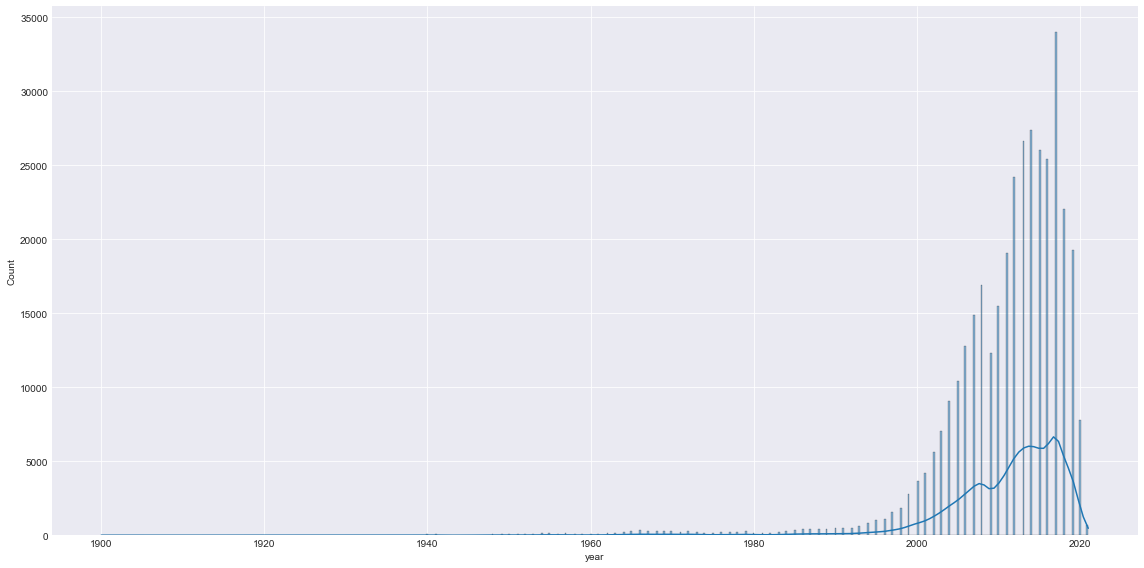

In [14]:
sns.displot(x=train_set.year, kde=True, height=8, aspect=2 )
plt.show()

### Drop outlier year records with .10 and 0.999 percntile range

In [15]:
est = OutlierExtraction({"year":[0.10, 0.98]})
train_set = est.fit_transform(train_set)

### Year distribution after outlier removal

In [16]:
train_set.year.describe()

count    330857.000000
mean       2012.746498
std           4.478442
min        2003.000000
25%        2009.000000
50%        2013.000000
75%        2017.000000
max        2020.000000
Name: year, dtype: float64

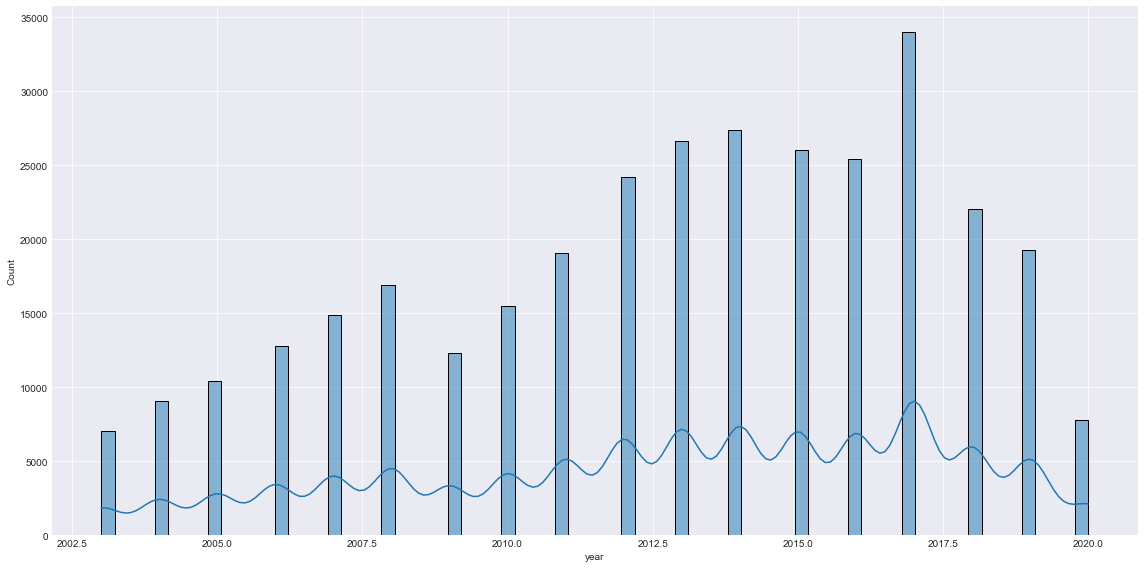

In [17]:
sns.displot(x=train_set.year, kde=True, height=8, aspect=2 )
plt.show()

### Check distribution and outlier for odometer

In [18]:
train_set.odometer.describe()

count    2.955000e+05
mean     9.900233e+04
std      3.767820e+06
min      0.000000e+00
25%      3.960200e+04
50%      8.439400e+04
75%      1.297135e+05
max      2.043756e+09
Name: odometer, dtype: float64

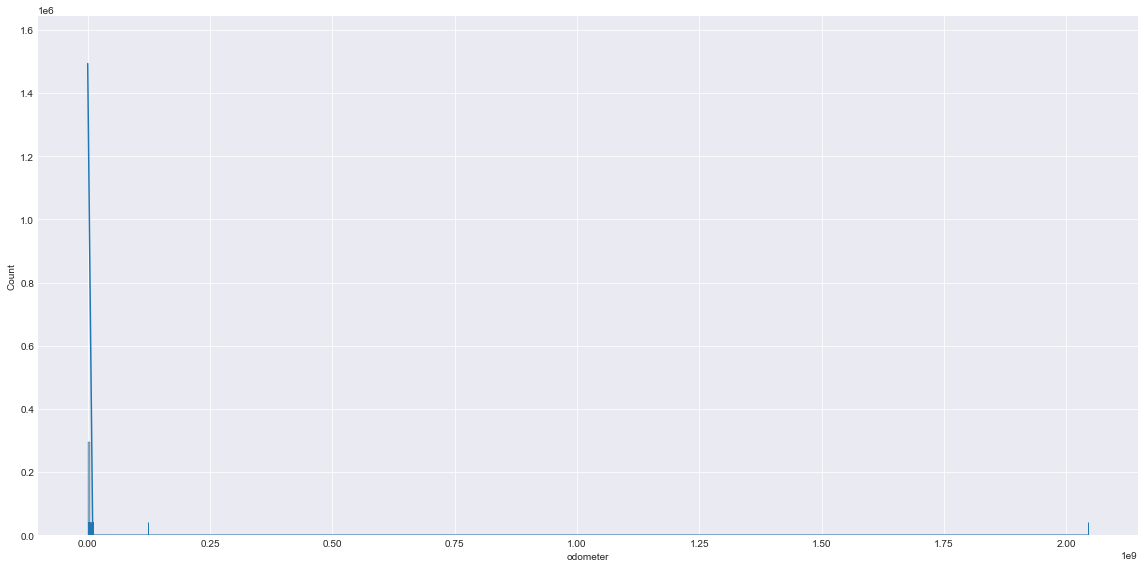

In [19]:
sns.displot(x=train_set.odometer, kde=True, rug=True, height=8, bins=500, aspect=2 )
plt.show()

### Drop records with outlier odometer

In [20]:
est = OutlierExtraction({"odometer":[0, 0.90]})
train_set = est.fit_transform(train_set)

In [21]:
train_set.odometer.describe()

count    266503.000000
mean      77115.397579
std       46769.275452
min           0.000000
25%       35970.500000
50%       75664.000000
75%      114899.000000
max      170000.000000
Name: odometer, dtype: float64

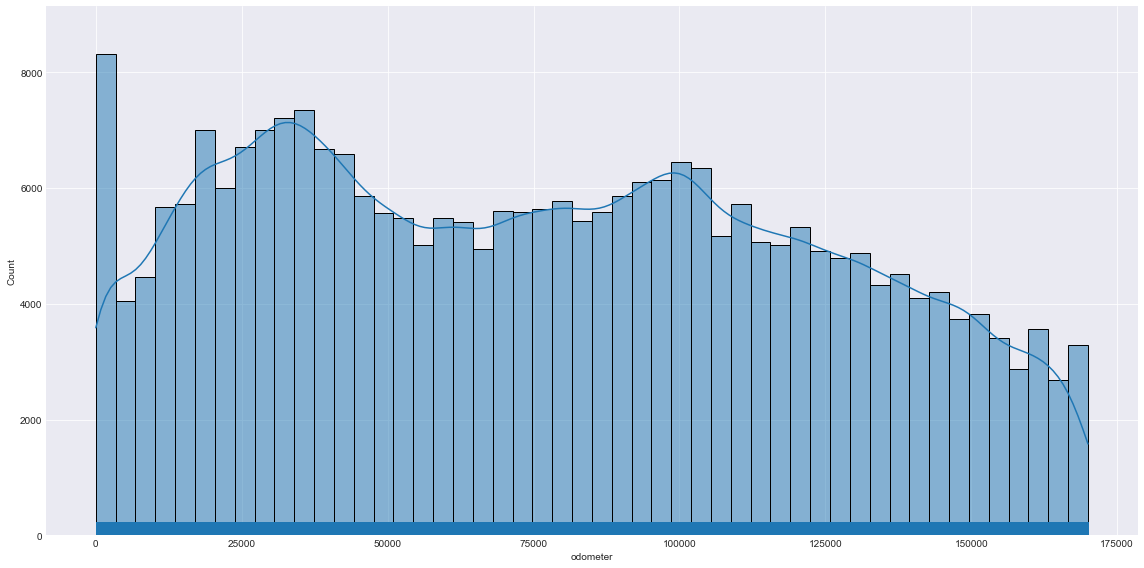

In [22]:
sns.displot(x=train_set.odometer, kde=True, rug=True, height=8, bins=50, aspect=2 )
plt.show()

### Check distribution and outlier for price

In [23]:
train_set.price.describe()

count    2.665030e+05
mean     3.136717e+04
std      7.009808e+06
min      0.000000e+00
25%      6.596000e+03
50%      1.390000e+04
75%      2.459000e+04
max      3.615215e+09
Name: price, dtype: float64

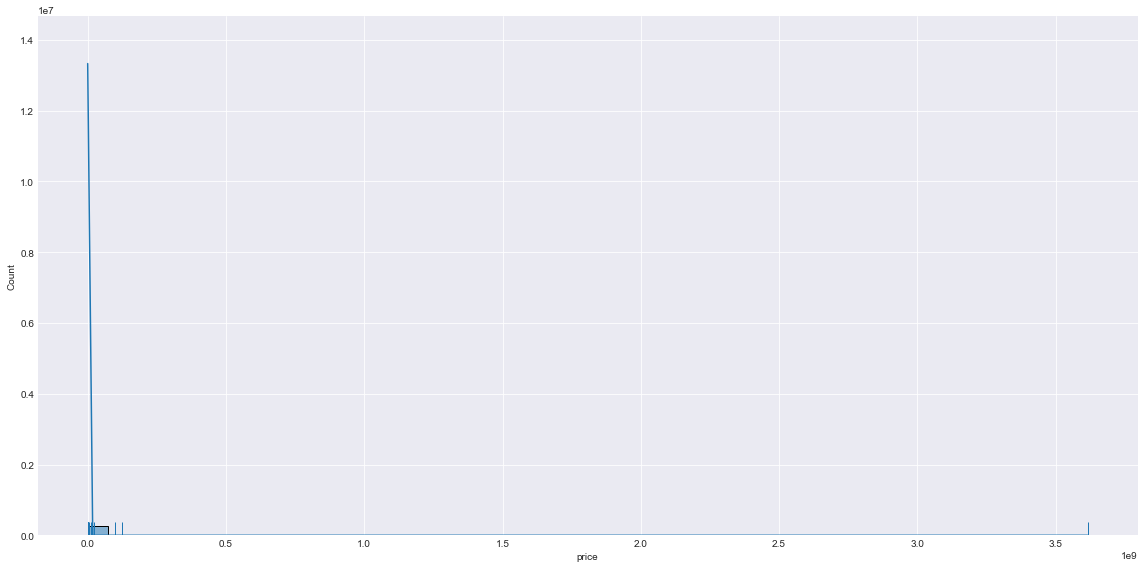

In [24]:
sns.displot(x=train_set.price, kde=True, rug=True, height=8, bins=50, aspect=2 )
plt.show()

### Drop outlier price records 

In [25]:
est = OutlierExtraction({"price":[0.15, 0.97]})
train_set = est.fit_transform(train_set)

In [26]:
train_set.price.describe()

count    218774.000000
mean      18092.479253
std       10548.599616
min        3990.000000
25%        9000.000000
50%       15795.000000
75%       25495.000000
max       46995.000000
Name: price, dtype: float64

### Year distribution after outlier removal

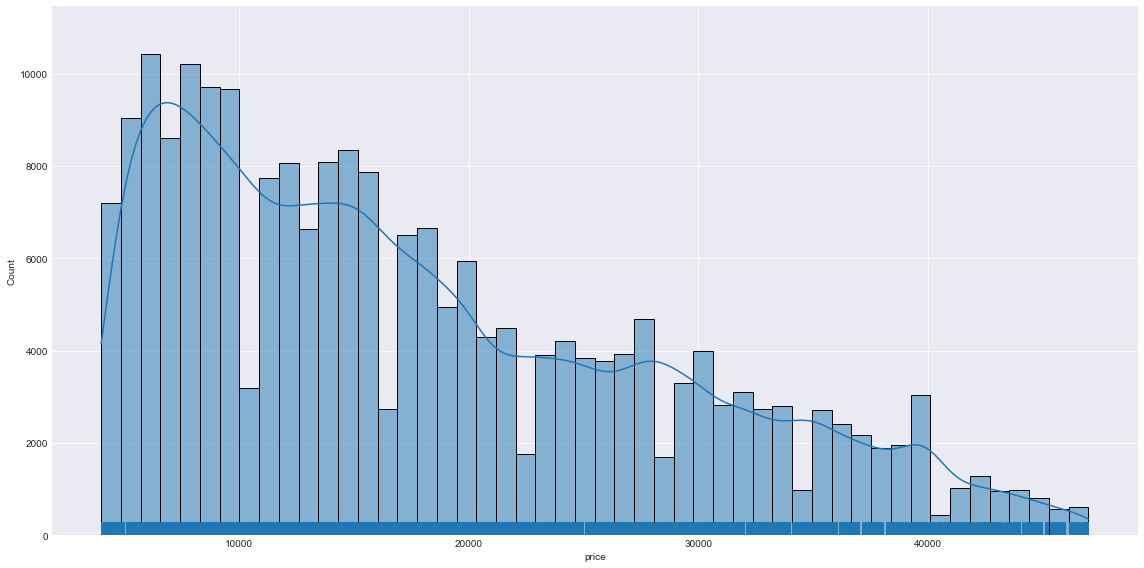

In [27]:
sns.displot(x=train_set.price, kde=True, rug=True, height=8, bins=50, aspect=2 )
plt.show()

### Find Missing Values

In [28]:
train_set.isnull().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer      4362
model              907
condition        84290
cylinders            0
fuel              1607
odometer             0
title_status      1006
transmission       967
VIN              61852
drive            53097
size            156885
type             36392
paint_color      51209
image_url            0
description         33
state                0
lat               1685
long              1685
posting_date         0
dtype: int64

### Find empty strings in cylinder columns

In [29]:
test = train_set.cylinders[train_set.cylinders == ""]
test.count()

74845

### Create class that can be used in pipeline to replace blank values with NaN

In [30]:
class ReplaceBlankValues(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X):
        for col in X.columns: 
            ser = X[col]
            ser[ser == ""] = np.NaN
        return X

    def fit(self, X, y = None):
        return self

In [31]:
transfomer = ReplaceBlankValues()
df_temp = pd.DataFrame(transfomer.fit_transform(train_set))
df_temp.columns = train_set.columns
train_set = df_temp

In [32]:
train_set.isnull().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer      4362
model              907
condition        84290
cylinders        74845
fuel              1607
odometer             0
title_status      1006
transmission       967
VIN              61852
drive            53097
size            156885
type             36392
paint_color      51209
image_url            0
description         33
state                0
lat               1685
long              1685
posting_date         0
dtype: int64

### Bar to find columns with missing values more than 50%

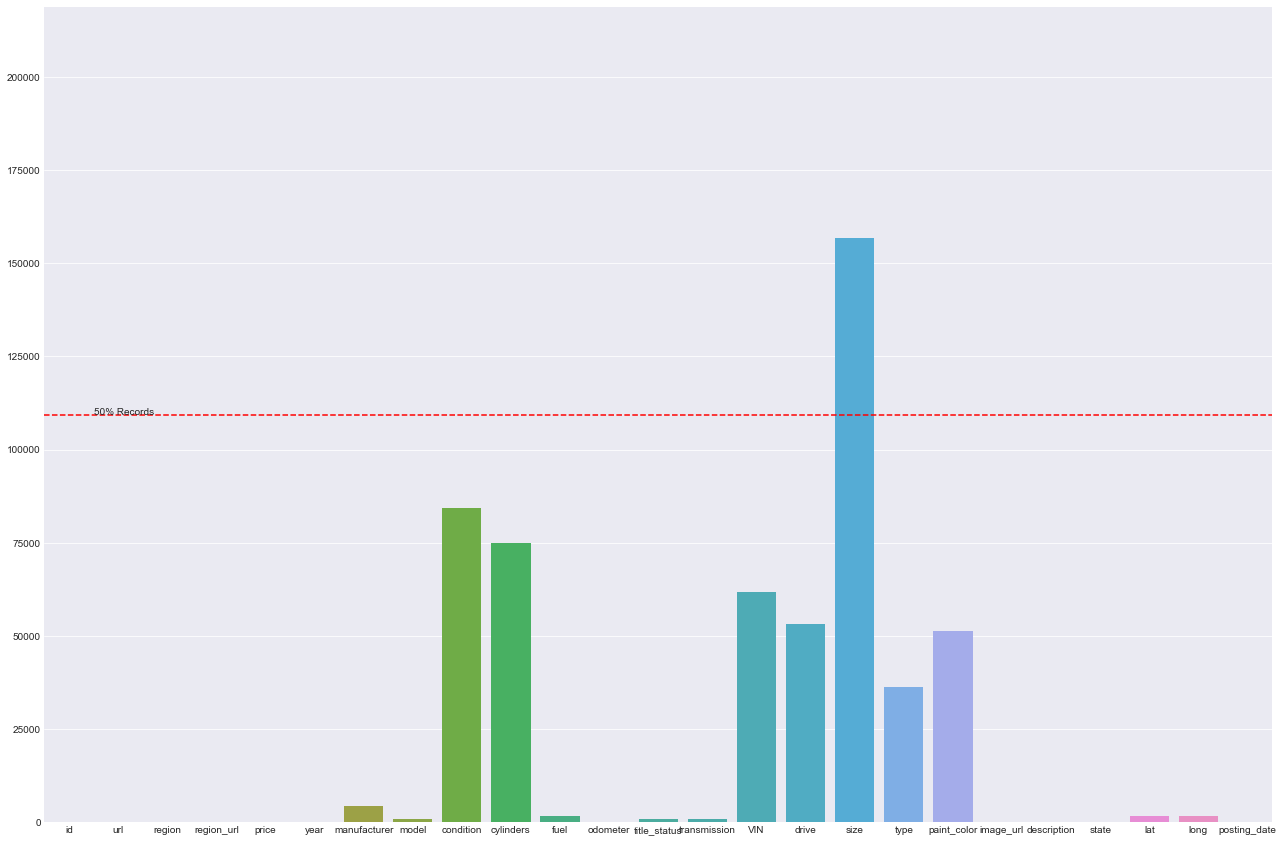

In [33]:
train_set.isnull().sum()
total = [len(train_set.index) for i in range(train_set.shape[1]) ]

fig, ax =plt.subplots(1,figsize=(22, 15))
g=sns.barplot(x=train_set.columns, y=train_set.isnull().sum())
ax1= g.axes
ax1.axhline(len(train_set.index)/2, ls='--', color="r")
ax1.text(0.5,len(train_set.index)/2, "50% Records")
plt.ylim(0, len(train_set.index))
plt.show()

### We can drop column size as it is having more than 50% missing values

In [34]:
train_set.drop(columns="size", inplace=True)
cat_attr.remove("size")

In [35]:
cat_attr

['region',
 'manufacturer',
 'model',
 'condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'paint_color',
 'state',
 'type']

#### Convert categorical features to numeric using Label Encoder

### Let's find out if train set has all categories from test, to avoid unknown categores in test set

for cat in cat_attr:
    tr = train_set[cat].unique()
    ts = test_set[cat].unique()
    notExists = [s for s in ts if s not in tr]
    print(cat, ":",len(notExists))

### Rather than dropping these records we decided to fit Ordinal encoder over whole dataset, 
Assumption this will not create data leakage issue

In [36]:
class MyLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.labelEncoders = {}
        self.attributes = attributes

    def transform(self, df):
        X = df.copy()
        for cat in self.attributes:
            label_encoder = self.labelEncoders[cat]
            nonulls = np.array(X[cat].dropna())
            impute_reshape = nonulls.reshape(-1,1)
            impute_ordinal = label_encoder.transform(impute_reshape)
            X[cat].loc[X[cat].notnull()] = np.squeeze(impute_ordinal)
        return X

    def fit(self, X, y = None):
        for cat in self.attributes:
            labelEncoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
            ser = X[cat].dropna()
            labelEncoder.fit(ser.to_numpy().reshape(-1,1))
            self.labelEncoders[cat] = labelEncoder       
        return self

In [37]:
transformer = MyLabelEncoder(cat_attr)
transformer.fit(train_set)

MyLabelEncoder(attributes=['region', 'manufacturer', 'model', 'condition',
                           'cylinders', 'fuel', 'title_status', 'transmission',
                           'drive', 'paint_color', 'state', 'type'])

In [38]:
trans_df = transformer.transform(train_set)

/home/sanjay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/sanjay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/sanjay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [39]:
trans_df[cat_attr].head(10)

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,paint_color,state,type
428050,169.0,15.0,2977.0,3.0,3.0,2.0,0.0,0.0,1.0,NaN,48.0,9.0
186119,44.0,29.0,11107.0,2.0,5.0,2.0,0.0,0.0,0.0,NaN,19.0,NaN
379234,96.0,29.0,15777.0,2.0,5.0,2.0,0.0,0.0,2.0,5.0,43.0,0.0
64763,374.0,29.0,15114.0,0.0,3.0,2.0,0.0,0.0,NaN,9.0,4.0,NaN
193169,49.0,7.0,3371.0,NaN,NaN,2.0,0.0,0.0,NaN,NaN,22.0,NaN
144582,31.0,7.0,13041.0,2.0,6.0,2.0,0.0,0.0,0.0,9.0,15.0,10.0
327153,275.0,32.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,9.0,37.0,8.0
256611,47.0,15.0,2977.0,NaN,3.0,2.0,0.0,0.0,1.0,8.0,31.0,9.0
202599,163.0,25.0,5734.0,NaN,5.0,2.0,0.0,0.0,NaN,0.0,22.0,9.0
93961,158.0,6.0,6444.0,NaN,6.0,2.0,0.0,0.0,0.0,0.0,9.0,0.0


In [40]:
imp_cols = np.append(num_attr, cat_attr)
imp_cols = np.append(imp_cols, ["price"])
trans_df[imp_cols].head()

,year,odometer,lat,long,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,paint_color,state,type,price
428050,2003.0,134578.0,43.118800,-87.947800,169.0,15.0,2977.0,3.0,3.0,2.0,0.0,0.0,1.0,NaN,48.0,9.0,3999
186119,2011.0,156300.0,41.673575,-70.266194,44.0,29.0,11107.0,2.0,5.0,2.0,0.0,0.0,0.0,NaN,19.0,NaN,6499
379234,2006.0,119000.0,31.817096,-106.561892,96.0,29.0,15777.0,2.0,5.0,2.0,0.0,0.0,2.0,5.0,43.0,0.0,5600
64763,2014.0,84000.0,34.226200,-118.447000,374.0,29.0,15114.0,0.0,3.0,2.0,0.0,0.0,NaN,9.0,4.0,NaN,5995
193169,2007.0,114614.0,43.182400,-84.112200,49.0,7.0,3371.0,NaN,NaN,2.0,0.0,0.0,NaN,NaN,22.0,NaN,11995


In [41]:
df_imputer = trans_df[imp_cols]

### Find good estimator to fill missing values for categorical features

#### Simple Imputer

In [42]:
score_simple_imputer = pd.DataFrame() #dataframe to store error of imputer
#computing MSE for mean and median
for strategy in ('mean', 'median'):
    X=df_imputer.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
    y = np.ravel(df_imputer.iloc[:,-1:])
    estimator = make_pipeline(
                    SimpleImputer(missing_values=np.NaN, strategy=strategy),
                    BayesianRidge()
                )
    
    score_simple_imputer[strategy] = cross_val_score(estimator, 
                                                     X, 
                                                     y, 
                                                     scoring='neg_mean_squared_error',
                                                     cv=None
                                     )


#### Iterative Imputers

In [43]:
# Estimate the score on the entire dataset by filling missing values by different iterative imputer


#estimators for IterativeImputer
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=random_state),
    ExtraTreesRegressor(n_estimators=10, random_state=random_state, n_jobs=15),
    KNeighborsRegressor(n_neighbors=10, n_jobs=15),
    #SGDRegressor(random_state=random_state),
    Lasso(random_state=random_state)
]
score_iterative_imputer = pd.DataFrame()
for esti in estimators:
        print("Estimating",esti.__class__.__name__)
        imputer = IterativeImputer(esti, random_state=random_state)
        df_new=df_imputer.copy()
        for col in df_imputer.columns:
            #col=check_imputer.columns[i]
            impute_data=imputer.fit_transform(df_new[col].values.reshape(-1,1))
            impute_data=impute_data.astype('int64')
            impute_data = pd.DataFrame(np.ravel(impute_data))
            df_new[col]=impute_data
            
        X=df_new.iloc[:,:-1]
        y = np.ravel(df_imputer.iloc[:,-1:])
        
        # Time being added this, need to investigate why imputer is returing columns with NaN
        X = X.fillna(X.median()).clip(-1e11,1e11)
        score_iterative_imputer[esti.__class__.__name__] = cross_val_score(esti,X,y,scoring='neg_mean_squared_error')

Estimating BayesianRidge
Estimating DecisionTreeRegressor
Estimating ExtraTreesRegressor
Estimating KNeighborsRegressor
Estimating Lasso


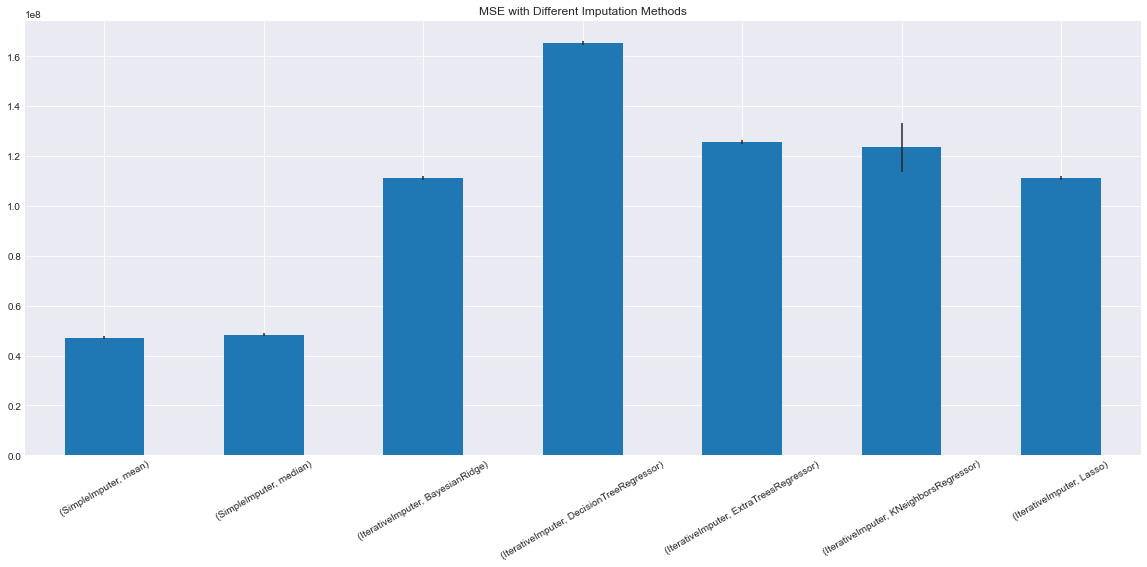



Method with Minimum Error ('SimpleImputer', 'median')


In [44]:
#ploting the graphs of scores each method
scores = pd.concat(
    [score_simple_imputer, score_iterative_imputer],
    keys=['SimpleImputer', 'IterativeImputer'], axis=1
)
fig, ax =plt.subplots(1,figsize=(20, 8))
means = -scores.mean()
errors = scores.std()
means.plot(kind="bar", yerr=errors)
plt.xticks(rotation=30)
plt.title("MSE with Different Imputation Methods")
plt.show()

print("\n\nMethod with Minimum Error", errors.idxmin())
name = errors.idxmin()

### Select Estimator for filling missing values

In [45]:
selected_est =  estimators[2]
print(selected_est)    

ExtraTreesRegressor(n_estimators=10, n_jobs=15, random_state=17)


### Fill missing values Atrributes

In [46]:
df_imputer.isnull().sum()

year                0
odometer            0
lat              1685
long             1685
region              0
manufacturer     4362
model             907
condition       84290
cylinders       74845
fuel             1607
title_status     1006
transmission      967
drive           53097
paint_color     51209
state               0
type            36392
price               0
dtype: int64

In [47]:
independent_vars = np.append(num_attr, cat_attr)
imputer=IterativeImputer(selected_est) 
imputed_data=imputer.fit_transform(df_imputer[independent_vars], df_imputer["price"])
df_imputer[independent_vars]=imputed_data
df_imputer.head()

/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
<ipython-input-47-d2e15fcef2af>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imputer[independent_vars]=imputed_data
/home/sanjay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1737: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v

,year,odometer,lat,long,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,paint_color,state,type,price
428050,2003.0,134578.0,43.118800,-87.947800,169.0,15.0,2977.0,3.0,3.0,2.0,0.0,0.0,1.0,7.3,48.0,9.0,3999
186119,2011.0,156300.0,41.673575,-70.266194,44.0,29.0,11107.0,2.0,5.0,2.0,0.0,0.0,0.0,4.1,19.0,0.0,6499
379234,2006.0,119000.0,31.817096,-106.561892,96.0,29.0,15777.0,2.0,5.0,2.0,0.0,0.0,2.0,5.0,43.0,0.0,5600
64763,2014.0,84000.0,34.226200,-118.447000,374.0,29.0,15114.0,0.0,3.0,2.0,0.0,0.0,0.9,9.0,4.0,8.5,5995
193169,2007.0,114614.0,43.182400,-84.112200,49.0,7.0,3371.0,0.6,4.1,2.0,0.0,0.0,0.9,3.3,22.0,7.6,11995


### Check if there are more missing values

In [48]:
df_imputer.isnull().sum()

year            0
odometer        0
lat             0
long            0
region          0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
title_status    0
transmission    0
drive           0
paint_color     0
state           0
type            0
price           0
dtype: int64

### Add age column from model year and posting date

In [49]:
class AddAgeColumn(BaseEstimator, TransformerMixin):
    def __init__(self, year_col_idx, posting_date_idx): # no *args or **kargs
        self.year_col_idx = year_col_idx
        self.posting_date_idx = posting_date_idx
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        inp = X.values
        year = (inp[:, self.year_col_idx] - 1).astype(int).astype(str)
        manu_year=np.char.add(year, "/09/30")
        manu_date = pd.Series(pd.to_datetime(manu_year, format="%Y/%m/%d", utc=True))
        ser = pd.Series(inp[:, self.posting_date_idx])
        #print(ser.dtypes)
        diff = pd.to_datetime(ser).subtract(manu_date)
        #print(diff)
        return np.c_[(diff/np.timedelta64(1, 'M'))]
  

In [50]:
attr_adder = AddAgeColumn(train_set.columns.get_loc("year"), train_set.columns.get_loc("posting_date"))
age_col = attr_adder.transform(train_set)

In [51]:
df_imputer["age_in_months"] = age_col
df_imputer.head()

<ipython-input-51-d1b17ef6d86c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imputer["age_in_months"] = age_col


,year,odometer,lat,long,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,paint_color,state,type,price,age_in_months
428050,2003.0,134578.0,43.118800,-87.947800,169.0,15.0,2977.0,3.0,3.0,2.0,0.0,0.0,1.0,7.3,48.0,9.0,3999,217.982963
186119,2011.0,156300.0,41.673575,-70.266194,44.0,29.0,11107.0,2.0,5.0,2.0,0.0,0.0,0.0,4.1,19.0,0.0,6499,121.488248
379234,2006.0,119000.0,31.817096,-106.561892,96.0,29.0,15777.0,2.0,5.0,2.0,0.0,0.0,2.0,5.0,43.0,0.0,5600,182.046879
64763,2014.0,84000.0,34.226200,-118.447000,374.0,29.0,15114.0,0.0,3.0,2.0,0.0,0.0,0.9,9.0,4.0,8.5,5995,85.282226
193169,2007.0,114614.0,43.182400,-84.112200,49.0,7.0,3371.0,0.6,4.1,2.0,0.0,0.0,0.9,3.3,22.0,7.6,11995,169.947912


### distribution plot for age in months

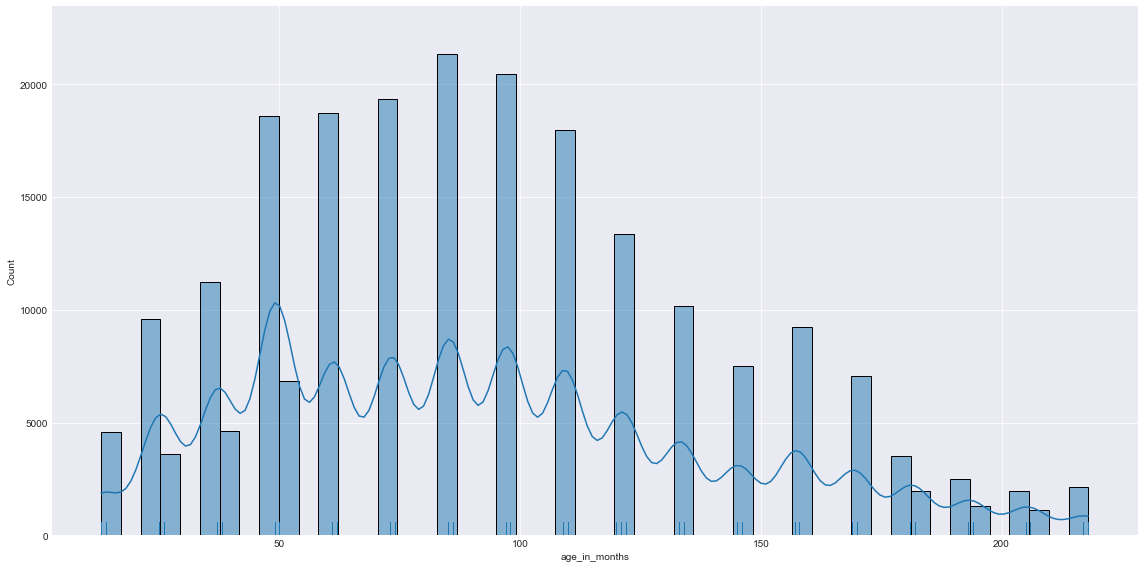

In [52]:
sns.displot(x=df_imputer.age_in_months.astype(int), kde=True, rug=True, height=8, bins=50, aspect=2 )
plt.show()

### Drop column posting date

In [53]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return  X[[b for b in list(X.columns) if b != self.attribute_name]]
        return X[self.attribute_names].values

#drop_col = DropColumns("posting_date")
#df_sel = pd.DataFrame( drop_col.transform(df_sel))

### Columns Selector

In [54]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
num_sel = ColumnSelector(num_attr)
#df_num_attrs = num_sel.transform(df_sel)

In [55]:
class Imputer(BaseEstimator, TransformerMixin):
    def __init__(self, est, independent_vars, target_var):
        self.est = est
        self.independent_vars = independent_vars
        self.target_var = target_var
    def fit(self, X, y=None):
        self.imputer = IterativeImputer(self.est) 
        self.imputer.fit(X[self.independent_vars], X[self.target_var])
        return self
    def transform(self, X):
        df_imp = X.copy()
        imputed_data = self.imputer.transform(X[self.independent_vars])
        df_imp[self.independent_vars]=imputed_data
        return df_imp


### Pipeline

In [56]:
outlier_removal = Pipeline([('outlier-removal', OutlierExtraction({"price":[0.10, 0.98], "year":[0.10, 0.999],"odometer":[0, 0.90]}))])

standard_scaler = StandardScaler()

pipeline_existing_cols = Pipeline([('replace-blank-with_NaN', ReplaceBlankValues()),
                                ('label-encoding',MyLabelEncoder(cat_attr)),# MyLabelEncoder(cat_attr)),
                                ('imputer', Imputer(selected_est, independent_vars, "price")),
                                ('column-selector', ColumnSelector(independent_vars)),
                                ])
pipeline_add_age = Pipeline([
                             ('add-age', AddAgeColumn(train_set_copy.columns.get_loc("year"), train_set_copy.columns.get_loc("posting_date")))
                            ])

feature_union = FeatureUnion(transformer_list=[
        ("existing_column", pipeline_existing_cols),
        ("added_cols", pipeline_add_age)
    ])

full_pipeline = Pipeline([("outlier_removal", outlier_removal),
                           ("transformation", feature_union),
                           ("scaling", StandardScaler()) 
                           ])

target_col_pipeline = Pipeline([("outlier_removal", outlier_removal),
                           ("column-selector", ColumnSelector(['price']))])

In [57]:
train_copy_df = train_set_copy.copy()
train_X = full_pipeline.fit_transform(train_copy_df)
train_X.shape

/home/sanjay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/sanjay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/sanjay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

(235206, 17)

In [58]:
train_Y = target_col_pipeline.fit_transform(train_copy_df)
train_Y.shape

(235206, 1)

In [59]:
from xgboost import XGBRegressor
model = XGBRegressor(importance_type='gain', n_jobs=15,gpu_id=0, objective='reg:squarederror', 
                     learning_rate= 0.3, max_depth= 20, n_estimators= 100, random_state=random_state )
model.fit(train_X, train_Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=20,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=15, num_parallel_tree=1, random_state=17,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
test_df = test_set.copy()
test_X = full_pipeline.transform(test_df)
test_Y = target_col_pipeline.transform(test_df)

/home/sanjay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/sanjay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/sanjay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [61]:
import sklearn.metrics
prediction = model.predict(test_X)
sklearn.metrics.r2_score(test_Y, prediction)

0.9219182092172007